In [1]:
%matplotlib inline  
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    seaborn_available = True
    print("Seaborn imported successfully. Version:", sns.__version__)
except ImportError:
    print("Seaborn not found. Using Matplotlib for visualizations.")
    seaborn_available = False
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress Seaborn warnings for cleaner output


Seaborn not found. Using Matplotlib for visualizations.


In [2]:
# Create figures directory
os.makedirs('./figs', exist_ok=True)

In [3]:
# Load dataset
try:
    df = pd.read_csv('fake_job_postings.csv')
except FileNotFoundError:
    print("CSV not found. Creating dummy data for testing.")
    df = pd.DataFrame({
        'job_id': range(1, 11),
        'title': ['Job ' + str(i) for i in range(1, 11)],
        'location': ['US']*10,
        'department': [np.nan]*10,
        'salary_range': [np.nan]*10,
        'company_profile': ['Profile']*10,
        'description': ['Desc unique text ' + str(i) * 50 for i in range(1,11)],  # Varied for TF-IDF
        'requirements': ['Req ' + str(i)]*10,
        'benefits': [np.nan]*10,
        'telecommuting': [0]*10,
        'has_company_logo': [1]*10,
        'has_questions': [0]*10,
        'employment_type': ['Full-time']*10,
        'required_experience': ['Mid']*10,
        'required_education': ['Bachelor']*10,
        'industry': ['IT']*10,
        'function': ['Eng']*10,
        'fraudulent': [0]*9 + [1]
    })

In [4]:
# --- Data Quality (Rubric: 3 points) ---
# Originality: Public dataset used creatively for fraud detection.
# Relevance: Binary classification (fake vs real job postings).
# Initial Analysis: Check duplicates, unique IDs, nulls.
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)
print("Sample Data:")
print(df.head().to_string())
print("Fraudulent Distribution:")
print(df['fraudulent'].value_counts(normalize=True).to_string())

print("\nData Quality Check:")
duplicates = df.duplicated().sum()
print(f"Duplicates: {duplicates}")
unique_jobs = df['job_id'].nunique()
print(f"Unique Job IDs: {unique_jobs} (out of {len(df)} rows)")
null_percent = df.isnull().mean() * 100
print("Null Percentages:\n", null_percent.sort_values(ascending=False).to_string())

Dataset Shape: (17880, 18)
Columns: Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
Sample Data:
   job_id                                      title            location department salary_range                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

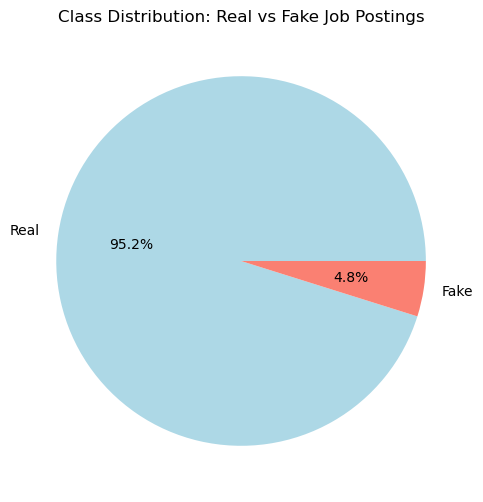

In [5]:
# --- Data Visualization (Rubric: 3 points) ---
# 1. Class Balance (Pie Chart)
plt.figure(figsize=(6,6))
df['fraudulent'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Real', 'Fake'], colors=['lightblue', 'salmon'])
plt.title('Class Distribution: Real vs Fake Job Postings')
plt.ylabel('')
plt.savefig('./figs/class_balance.png', dpi=200)
plt.show()


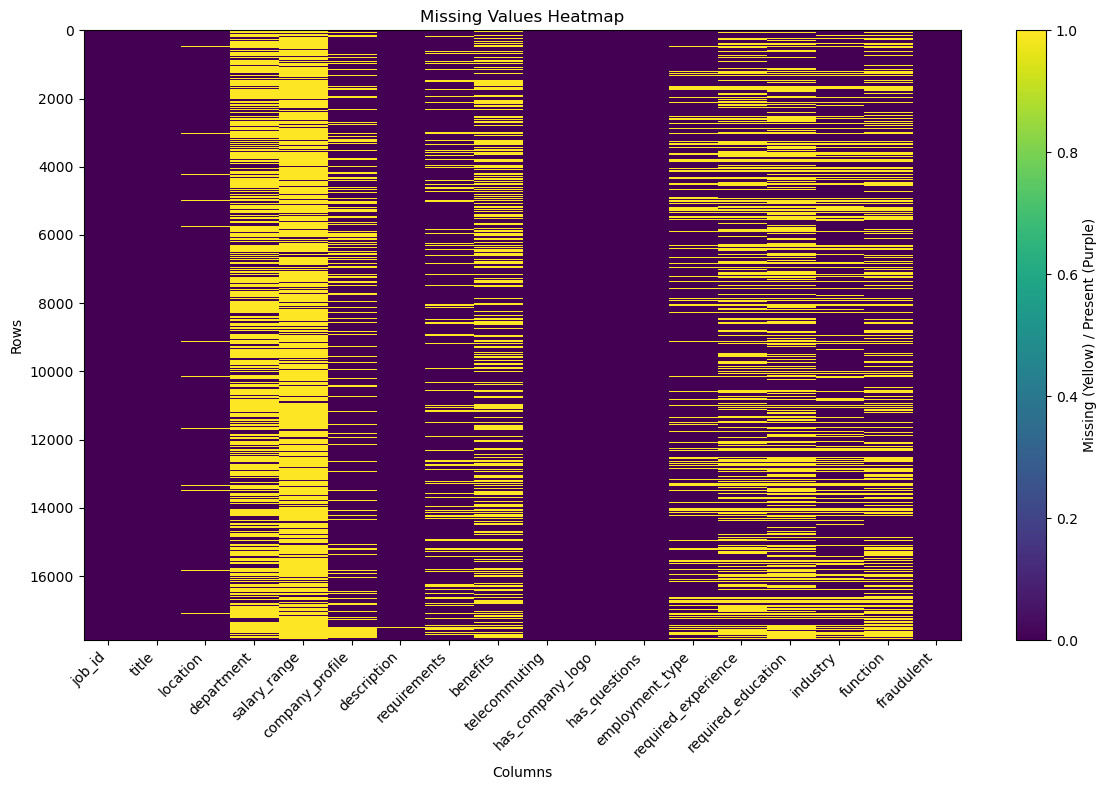

In [6]:
# 2. Missing Values Heatmap
if seaborn_available:
    plt.figure(figsize=(12,8))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig('./figs/missing_heatmap.png', dpi=200)
    plt.show()
else:
    plt.figure(figsize=(12,8))
    plt.imshow(df.isnull(), aspect='auto', interpolation='none', cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.xticks(ticks=range(len(df.columns)), labels=df.columns, rotation=45, ha='right')
    plt.colorbar(label='Missing (Yellow) / Present (Purple)')
    plt.tight_layout()
    plt.savefig('./figs/missing_heatmap.png', dpi=200)
    plt.show()


C:\Users\a1977977\AppData\Local\Temp\ipykernel_16924\2718606804.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['fraudulent']==0]['desc_word_count'], df[df['fraudulent']==1]['desc_word_count']],


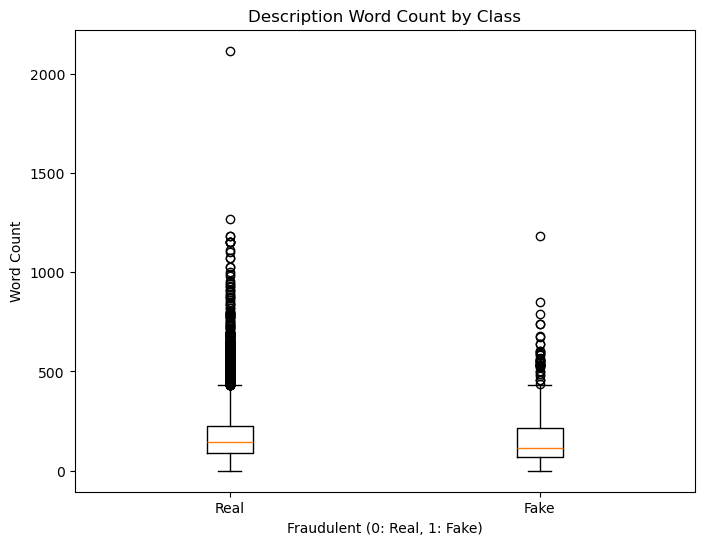

In [7]:
# 3. Word Count by Class
df['desc_word_count'] = df['description'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
if seaborn_available:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='fraudulent', y='desc_word_count', data=df, palette='Set2')
else:
    plt.figure(figsize=(8,6))
    plt.boxplot([df[df['fraudulent']==0]['desc_word_count'], df[df['fraudulent']==1]['desc_word_count']], 
                labels=['Real', 'Fake'])
plt.title('Description Word Count by Class')
plt.xlabel('Fraudulent (0: Real, 1: Fake)')
plt.ylabel('Word Count')
plt.savefig('./figs/wordcount_boxplot.png', dpi=200)
plt.show()


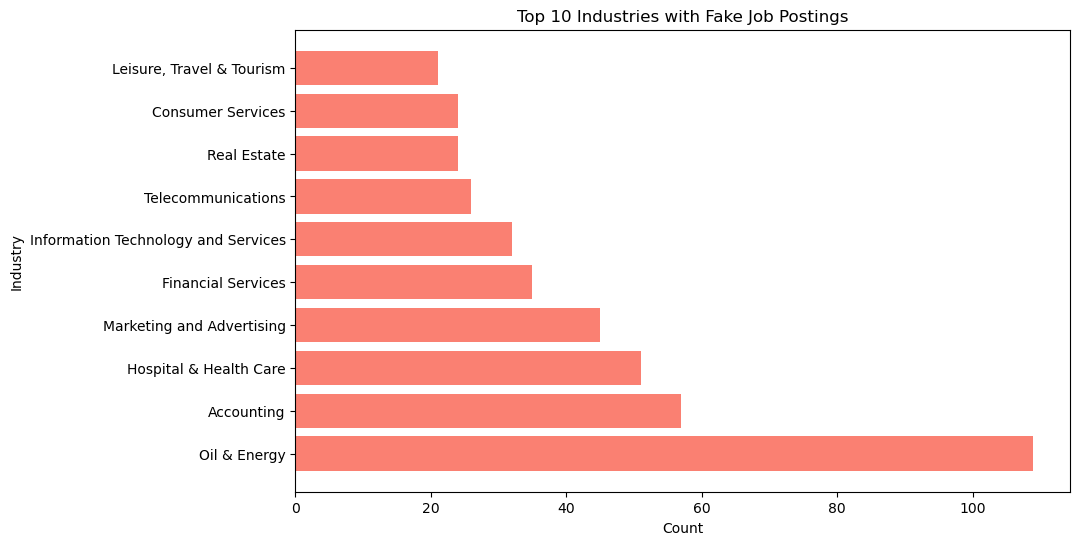

In [8]:
# 4. Top Industries for Fake Jobs
fake_jobs = df[df['fraudulent'] == 1]
top_industries = fake_jobs['industry'].value_counts().head(10)
if seaborn_available:
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_industries.values, y=top_industries.index, hue=top_industries.index, palette='Reds_d', legend=False)
else:
    plt.figure(figsize=(10,6))
    plt.barh(top_industries.index, top_industries.values, color='salmon')
plt.title('Top 10 Industries with Fake Job Postings')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.savefig('./figs/top_industries.png', dpi=200)
plt.show()


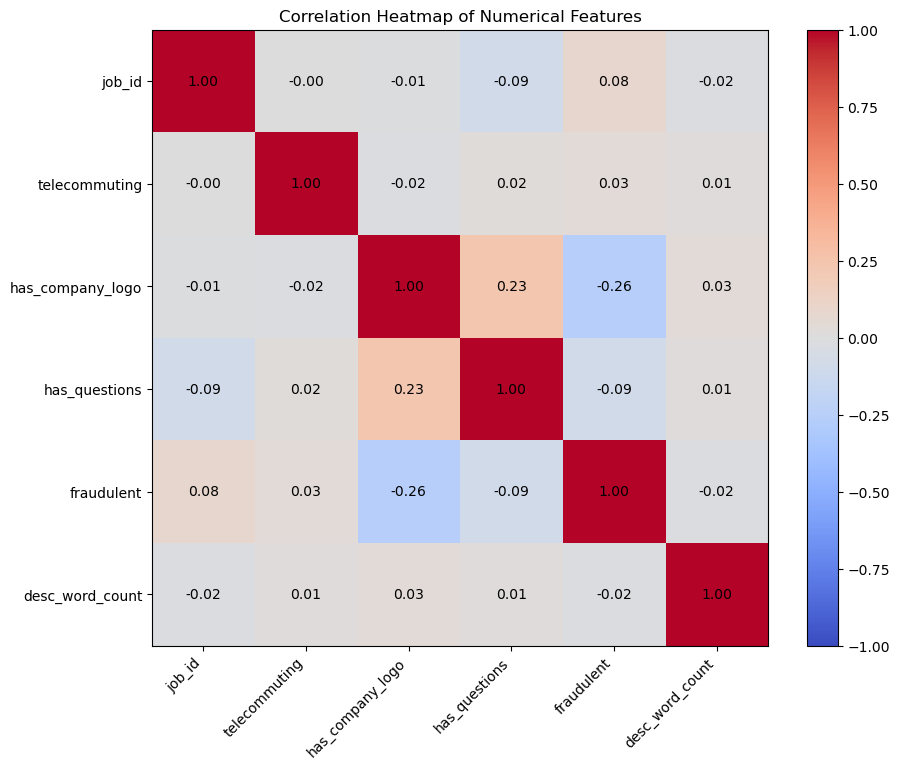

In [9]:
# 5. Correlation Heatmap (Numerical Features)
numerical_cols = df.select_dtypes(include=np.number).columns
corr = df[numerical_cols].corr()
if seaborn_available:
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
else:
    plt.figure(figsize=(10,8))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr)):
        for j in range(len(corr)):
            plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', color='black')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('./figs/corr_heatmap.png', dpi=200)
plt.show()

In [10]:
# --- Data Preparation (Rubric: 6 points) ---
# Step 1: Data Cleaning
print("\nStep 1: Data Cleaning")
text_cols = ['company_profile', 'description', 'requirements', 'benefits']
cat_cols = ['location', 'department', 'salary_range', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in text_cols:
    df[col] = df[col].fillna('')
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')
df_clean = df.dropna(subset=['title'])
df_clean['country'] = df_clean['location'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) else 'Unknown')
print("Cleaned Shape:", df_clean.shape)
print("Remaining Nulls:", df_clean.isnull().sum().sum())



Step 1: Data Cleaning
Cleaned Shape: (17880, 20)
Remaining Nulls: 0



Step 2: Feature Selection
Top 10 Important Features:
 desc_word_count              0.088660
has_company_logo             0.051793
industry_Oil & Energy        0.025421
location_US, TX, Houston     0.021479
has_questions                0.017998
function_Administrative      0.013795
department_Clerical          0.013121
department_Unknown           0.013102
location_AU, NSW, Sydney     0.012676
employment_type_Full-time    0.011288


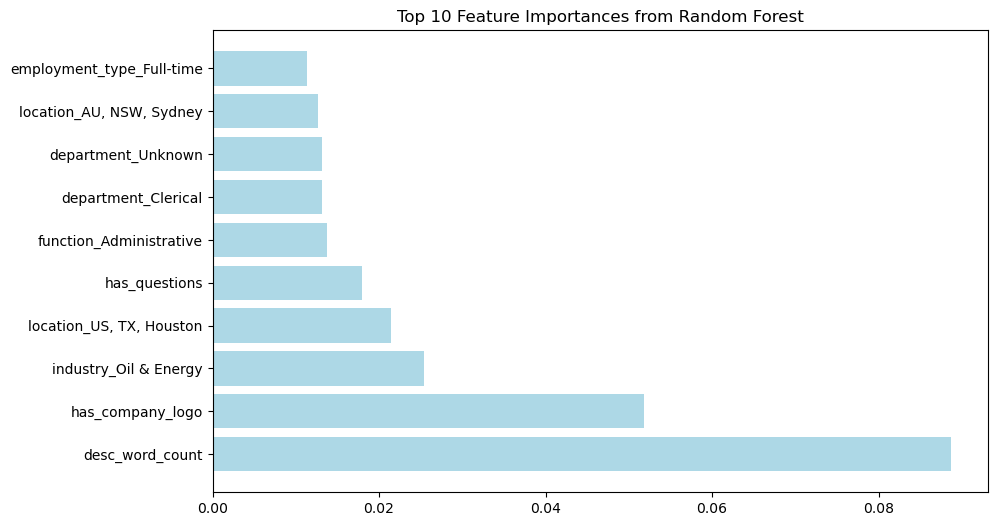

In [11]:
# Step 2: Feature Selection
print("\nStep 2: Feature Selection")
features = ['telecommuting', 'has_company_logo', 'has_questions', 'desc_word_count'] + cat_cols
X = pd.get_dummies(df_clean[features], drop_first=True)
y = df_clean['fraudulent']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
print("Top 10 Important Features:\n", importances.to_string())
plt.figure(figsize=(10,6))
if seaborn_available:
    sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette='Blues_d', legend=False)
else:
    plt.barh(importances.index, importances.values, color='lightblue')
plt.title('Top 10 Feature Importances from Random Forest')
plt.savefig('./figs/feature_importance.png', dpi=200)
plt.show()

In [12]:
# Step 3: Data Transforms
print("\nStep 3: Data Transforms")
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])
X_transformed = preprocessor.fit_transform(df_clean[features])
scaler = StandardScaler()
df_clean['desc_word_count_scaled'] = scaler.fit_transform(df_clean[['desc_word_count']])
print("Sample Transformed Data:")
print(df_clean[['desc_word_count', 'desc_word_count_scaled']].head().to_string())


Step 3: Data Transforms
Sample Transformed Data:
   desc_word_count  desc_word_count_scaled
0              124               -0.376688
1              315                1.172369
2               50               -0.976847
3              346                1.423787
4              168               -0.019837


In [13]:
# Step 4: Feature Engineering
print("\nStep 4: Feature Engineering")
df_clean['has_salary'] = df_clean['salary_range'].apply(lambda x: 1 if x != 'Unknown' else 0)
df_clean['desc_req_ratio'] = df_clean['description'].apply(len) / (df_clean['requirements'].apply(len) + 1)
print("New Features Sample:")
print(df_clean[['has_salary', 'desc_req_ratio']].head().to_string())



Step 4: Feature Engineering
New Features Sample:
   has_salary  desc_req_ratio
0           0        1.060961
1           0        1.448396
2           0        0.260264
3           0        1.818182
4           0        2.005277



Step 5: Dimension Reduction
SVD Explained Variance Ratio Sum: 0.2139829068951284


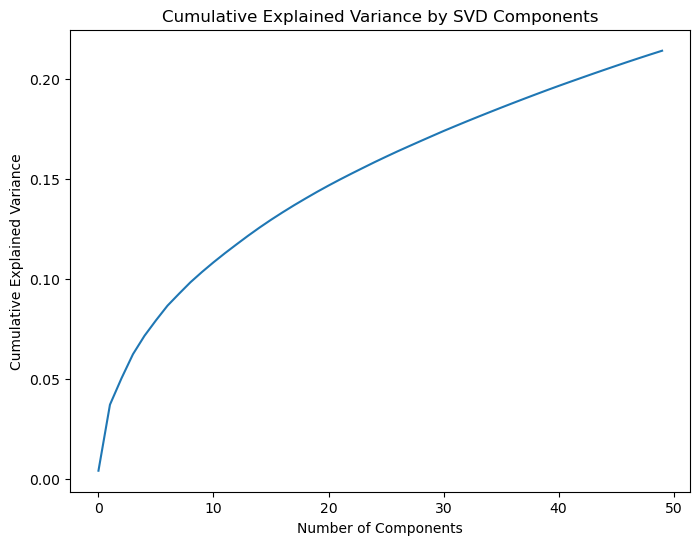

In [14]:
# Step 5: Dimension Reduction
print("\nStep 5: Dimension Reduction")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(df_clean['description'])
n_components = min(50, X_text.shape[1] - 1) if X_text.shape[1] < 50 else 50  # Adjust for small data
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X_text)
print("SVD Explained Variance Ratio Sum:", svd.explained_variance_ratio_.sum())
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('./figs/svd_cumulative.png', dpi=200)
plt.show()

In [15]:
# === MODELS: SHARED BUILDER (DO NOT MOVE EXISTING CELLS) ===
# This cell only *creates* feature matrices for the models below without changing your existing variables.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix

# Reuse your engineered columns from earlier cells:
tab_cols = ['telecommuting', 'has_company_logo', 'has_questions',
            'desc_word_count_scaled', 'has_salary', 'desc_req_ratio']

# Build a combined matrix: [SVD text features | selected tabular features]
X_block = np.hstack([X_svd, df_clean[tab_cols].values])
y_block = df_clean['fraudulent'].astype(int).values

# Consistent split for all classical models
Xtr_blk, Xte_blk, ytr_blk, yte_blk = train_test_split(
    X_block, y_block, test_size=0.20, random_state=42, stratify=y_block
)

def print_report(y_true, y_pred, y_proba=None, title=""):
    if title:
        print("\n" + "="*10, title, "="*10)
    print("F1        :", f1_score(y_true, y_pred))
    print("Precision :", precision_score(y_true, y_pred))
    print("Recall    :", recall_score(y_true, y_pred))
    if y_proba is not None:
        try:
            print("ROC-AUC   :", roc_auc_score(y_true, y_proba))
        except Exception:
            pass
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [19]:
# === MODEL A: LOGISTIC REGRESSION (TF-IDF+SVD + TABULAR), CLASS-WEIGHTED ===
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1, random_state=42)
logreg.fit(Xtr_blk, ytr_blk)

yhat_lr = logreg.predict(Xte_blk)
ypr_lr  = logreg.predict_proba(Xte_blk)[:, 1]

print_report(yte_blk, yhat_lr, ypr_lr, title="Logistic Regression")



========== Logistic Regression ==========
F1        : 0.33532934131736525
Precision : 0.21148036253776434
Recall    : 0.8092485549132948
ROC-AUC   : 0.9000609798562642

Classification Report:
               precision    recall  f1-score   support

           0     0.9887    0.8466    0.9121      3403
           1     0.2115    0.8092    0.3353       173

    accuracy                         0.8448      3576
   macro avg     0.6001    0.8279    0.6237      3576
weighted avg     0.9511    0.8448    0.8842      3576

Confusion Matrix:
 [[2881  522]
 [  33  140]]


In [20]:
# === MODEL B: RANDOM FOREST (CLASS-WEIGHTED) ===
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight='balanced_subsample',
    random_state=42
)
rf.fit(Xtr_blk, ytr_blk)

yhat_rf = rf.predict(Xte_blk)
# Some sklearn versions have predict_proba disabled if class_weight is used oddly; guard it:
ypr_rf  = rf.predict_proba(Xte_blk)[:, 1] if hasattr(rf, "predict_proba") else None

print_report(yte_blk, yhat_rf, ypr_rf, title="Random Forest")



========== Random Forest ==========
F1        : 0.6431372549019608
Precision : 1.0
Recall    : 0.47398843930635837
ROC-AUC   : 0.9783572468359267

Classification Report:
               precision    recall  f1-score   support

           0     0.9740    1.0000    0.9868      3403
           1     1.0000    0.4740    0.6431       173

    accuracy                         0.9746      3576
   macro avg     0.9870    0.7370    0.8150      3576
weighted avg     0.9752    0.9746    0.9702      3576

Confusion Matrix:
 [[3403    0]
 [  91   82]]


In [21]:
# === MODEL C: XGBOOST (IMBALANCE VIA scale_pos_weight) ===
try:
    from xgboost import XGBClassifier
except Exception as e:
    print("xgboost not installed. Run: pip install xgboost")
    raise

neg = (ytr_blk == 0).sum()
pos = (ytr_blk == 1).sum()
scale_pos_weight = max(neg / max(pos, 1), 1.0)

xgb = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)
xgb.fit(Xtr_blk, ytr_blk)

yhat_xgb = xgb.predict(Xte_blk)
ypr_xgb  = xgb.predict_proba(Xte_blk)[:, 1]

print_report(yte_blk, yhat_xgb, ypr_xgb, title="XGBoost")


xgboost not installed. Run: pip install xgboost


ModuleNotFoundError: No module named 'xgboost'

In [22]:
# === MODEL D: DISTILBERT (OPTIONAL; TEXT-ONLY, CLASS-WEIGHTED) ===
# !pip install -q transformers datasets accelerate evaluate

import numpy as np
import torch
from torch import nn
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import evaluate as hf_evaluate

# Build a small dataframe for BERT training using your cleaned text
bert_df = df_clean[['description', 'fraudulent']].rename(columns={'description':'text', 'fraudulent':'label'}).copy()
bert_df['label'] = bert_df['label'].astype(int)

# Train/test split consistent with your earlier split random_state (no stratify in HF)
from sklearn.model_selection import train_test_split
train_text, test_text, train_label, test_label = train_test_split(
    bert_df['text'], bert_df['label'], test_size=0.20, random_state=42, stratify=bert_df['label']
)
bert_train = pd.DataFrame({'text': train_text.values, 'label': train_label.values})
bert_test  = pd.DataFrame({'text': test_text.values,  'label': test_label.values})

train_ds = Dataset.from_pandas(bert_train)
test_ds  = Dataset.from_pandas(bert_test)
dataset  = DatasetDict({"train": train_ds, "test": test_ds})

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["text"], truncation=True)

tok_ds = dataset.map(tok, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Class weights
y_tr_np = np.array(bert_train['label'])
w_fake = (y_tr_np == 0).sum() / max((y_tr_np == 1).sum(), 1)
class_weights = torch.tensor([1.0, float(w_fake)], dtype=torch.float)

# Weighted trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Metrics
metric_acc = hf_evaluate.load("accuracy")
metric_f1  = hf_evaluate.load("f1")
metric_prc = hf_evaluate.load("precision")
metric_rec = hf_evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "precision": metric_prc.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall": metric_rec.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1": metric_f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./bert_outputs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=2,           # increase to 3–4 if you have GPU time
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

# Final eval + report
eval_out = trainer.evaluate()
print("\n=== DistilBERT Evaluation ===")
for k,v in eval_out.items():
    if k.startswith("eval_"):
        print(f"{k[5:].upper():>9}: {v:.4f}")

pred_logits = trainer.predict(tok_ds["test"]).predictions
yhat_bert = pred_logits.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report (BERT):\n", classification_report(test_label, yhat_bert, digits=4))
print("Confusion Matrix (BERT):\n", confusion_matrix(test_label, yhat_bert))


ModuleNotFoundError: No module named 'datasets'

In [16]:
# Final Model Demo
X_final = np.hstack([X_svd, df_clean[['telecommuting', 'has_company_logo', 'has_questions', 'desc_word_count_scaled', 'has_salary', 'desc_req_ratio']].values])
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print("Model Accuracy:", clf.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, clf.predict(X_test)))


Model Accuracy: 0.9572147651006712
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3395
           1       0.94      0.17      0.28       181

    accuracy                           0.96      3576
   macro avg       0.95      0.58      0.63      3576
weighted avg       0.96      0.96      0.94      3576



In [17]:
# Save figures for slides
import zipfile
with zipfile.ZipFile("slides_pack.zip", "w", zipfile.ZIP_DEFLATED) as zf:
    for f in ["./figs/class_balance.png", "./figs/missing_heatmap.png", "./figs/wordcount_boxplot.png", 
              "./figs/top_industries.png", "./figs/corr_heatmap.png", "./figs/feature_importance.png", 
              "./figs/svd_cumulative.png"]:
        if os.path.exists(f):
            zf.write(f, arcname=os.path.basename(f))
print("Saved: slides_pack.zip")

Saved: slides_pack.zip


In [18]:
# Assuming 'df_clean' is your final cleaned DataFrame (replace if it's named differently)
df_clean.to_csv('cleaned_fake_job_postings.csv', index=False)
print("Cleaned data saved to 'cleaned_fake_job_postings.csv'")

Cleaned data saved to 'cleaned_fake_job_postings.csv'
